<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Integrating Word2Vec**


Estimated time needed: **60** minutes


"The worlds most valuable resource is no longer oil, but data", you hear that a lot, but did you ever wonder what that really means. Through word2vec, you'll unlock the power of words in large datasets, providing you with the tools to tackle real-world problems effectively.
 <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/data_oil.png" alt="new oild">
    


Here, you will be introduced to the Skip-gram and CBOW models, teaching how to build and apply these for text classification in PyTorch. You'll also incorporate pretrained GloVe embeddings to enhance the models. An optional section on advanced embedding applications is available for further exploration. By the end of this lab, you'll be adept at using word embeddings for natural language processing (NLP) tasks.


## __Table of Contents__

<ol>
    <li><a href="#Objectives">Objectives</a></li>
    <li>
        <a href="#Setup">Setup</a>
        <ol>
            <li><a href="#Installing-required-libraries">Installing required libraries</a></li>
            <li><a href="#Importing-Required-Libraries">Importing required libraries</a></li>
        </ol>
    </li>
    <li>
        <a href="#Background">Background</a>
        <ol>
            <li><a href="#Word2Vec">Word2Vec</a></li>
            <li><a href="#GloVe-(Optional)">GloVe (Optional)</a></li>
        </ol>
    </li>
    <li><a href="#Create-and-train-word2vec-models">Create and train word2vec models</a></li>
        <ol>
            <li><a href="#Continuous-Bag-of-Words-(CBOW)">Continuous Bag of Words (CBOW)</a></li>
            <li><a href="#Skip-gram-model">Skip-gram model</a></li>
        </ol>
    <li><a href="#Applying-pretrained-word-embeddings-(optional)">Applying pretrained word embeddings (optional)</a></li>
        <ol>
            <li><a href="#Load-Stanford-GloVe-model">Load Stanford GloVe model</a></li>
            <li><a href="#Train-a-word2vec-model-from-gensim">Train a word2vec model from gensim</a></li>
        </ol>
     <li><a href="#Text-classification-using-pretrained-word-embeddings">Text classification using pretrained word embeddings</a>
</ol>


## Objectives

After completing this lab you will be able to:
- Comprehend word embedding with word2vec.
- Create and train basic word2vec models using CBOW and Skip-gram architectures.
- Get pretrained large embedding models and generate word embeddings with them.
- Train a word2vec model on a domain-specific data.


----


## Setup


For this lab, you will be using the following libraries:

*   [`torch`](https://pandas.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for building NN models and preparing the data.
*   [`numpy`](https://numpy.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for mathematical operations.
*   [`gensim`](https://pypi.org/project/gensim/) for word2vec pretrained models.
*   [`seaborn`](https://seaborn.pydata.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for visualizing the data.
*   [`matplotlib`](https://matplotlib.org/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML0187ENSkillsNetwork31430127-2021-01-01) for additional plotting tools.


### Installing required libraries
<h2 style="color:red;">After installing the libraries below please RESTART THE KERNEL and run all cells.</h2>


The following required libraries are __not__ pre-installed in the Skills Network Labs environment. __You will need to run the following cell__ to install them:


### Importing required libraries

_It is recommended that you import all required libraries in one place (here):_


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from collections import Counter
from tqdm import tqdm

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import gensim
from gensim.models import Word2Vec

import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt_tab')

#Suupress warnings
def warn(*args,**kwargs):
  pass
import warnings
warnings.warn=warn
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


Define a function to plot word embeddings in a 2d space.


In [2]:
def plot_embeddings(word_embeddings, vocab):
    tsne = TSNE(n_components=2, random_state=0)
    word_embeddings_2d = tsne.fit_transform(word_embeddings)

    # Plotting the results with labels from vocab
    plt.figure(figsize=(15, 15))
    for word, idx in vocab.items():  # vocab is a dictionary now
        plt.scatter(word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1])
        plt.annotate(word, (word_embeddings_2d[idx, 0], word_embeddings_2d[idx, 1]))

    plt.xlabel("t-SNE component 1")
    plt.ylabel("t-SNE component 2")
    plt.title("Word Embeddings visualized with t-SNE")
    plt.show()

Define a function that returns similar words to a specific word by calculating Cosine distance.


In [3]:
import numpy as np
import torch

def find_similar_words(word, word_embeddings, top_k=5):
    # Check if the word exists in the embeddings dictionary
    if word not in word_embeddings:
        print("Word not found in embeddings")
        return []

    # Get the embedding for the given word and convert it to a tensor
    target_embedding = torch.tensor(word_embeddings[word])

    # Dictionary to store cosine similarities of all words with the target word
    similarities = {}

    # Iterate through all words and their embeddings
    for w, embedding in word_embeddings.items():
        if w != word:  # Skip the target word itself
            embedding_tensor = torch.tensor(embedding)  # Convert embedding to tensor

            # Compute cosine similarity between target word and the current word
            similarity = torch.dot(target_embedding, embedding_tensor) / (
                torch.norm(target_embedding) * torch.norm(embedding_tensor)
            )

            # Store similarity score in the dictionary
            similarities[w] = similarity.item()

    # Sort the words based on similarity scores in descending order
    sorted_similarities = sorted(similarities.items(), key=lambda x: x[1], reverse=True)

    # Extract the top k most similar words
    most_similar_words = [w for w, _ in sorted_similarities[:top_k]]

    return most_similar_words


Define a function that trains word2vec model on toy data.


In [4]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=100):
    """
    Train the model for the specified number of epochs.

    Args:
        model: The PyTorch model to be trained.
        dataloader: DataLoader providing data for training.
        criterion: Loss function.
        optimizer: Optimizer for updating model's weights.
        num_epochs: Number of epochs to train the model for.

    Returns:
        model: The trained model.
        epoch_losses: List of average losses for each epoch.
    """

    # List to store average loss for each epoch
    epoch_losses = []

    # Loop over the specified number of epochs
    for epoch in tqdm(range(num_epochs), desc="Training Progress"):
        running_loss = 0.0  # Initialize running loss for the current epoch

        # Iterate over batches from the dataloader
        for idx, samples in enumerate(dataloader):
            optimizer.zero_grad()  # Reset gradients before each batch

            # Check if the model contains an EmbeddingBag layer
            if any(isinstance(module, nn.EmbeddingBag) for _, module in model.named_modules()):
                target, context, offsets = samples  # Unpack batch samples
                predicted = model(context, offsets)  # Forward pass

            # Check if the model contains an Embedding layer
            elif any(isinstance(module, nn.Embedding) for _, module in model.named_modules()):
                target, context = samples  # Unpack batch samples
                predicted = model(context)  # Forward pass

            loss = criterion(predicted, target)  # Compute loss
            loss.backward()  # Backpropagate the gradients

            # Clip gradients to prevent exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()  # Update model weights

            running_loss += loss.item()  # Accumulate loss

        # Compute average loss for the epoch and store it
        epoch_losses.append(running_loss / len(dataloader))

    return model, epoch_losses


# Background

## Word2Vec

Word2Vec is a family of  methods that transforms words into number vectors, positioning similar words close together in a space defined by these numbers. This way, you can quantify and analyze word relationships mathematically. For instance, words like "cat" and "kitten" or "cat" and "dog" have vectors that are close to each other, while a word like "book" is positioned further away in this vector space.


<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/Words.png" alt="Word2Vec example" class="bg-primary" width="400px">



In this lab session, you'll concentrate on mastering Skip-gram and Continuous Bag of Words (CBOW) models, which are essential precursors to grasping the principles of generative modeling. Additionally, you'll explore the GloVe model, and an **optional** summary will be provided to enhance your understanding of its application in natural language processing.
## GloVe (Optional)



GloVe, on the other hand, is another popular algorithm for learning word embeddings. It stands for Global Vectors for Word Representation. Unlike word2vec, which is based on predicting context/target words, GloVe focuses on capturing the global word co-occurrence statistics from the entire corpus. It constructs a co-occurrence matrix that represents how often words appear together in the text. The matrix is then factorized to obtain the word embeddings. For example, if "Man" and "King" co-occure many times, their vectors will be simialr.

The GloVe model follows a fundamental approach by constructing a large word-context co-occurrence matrix that contains pairs of (word, context). Each entry in this matrix represents the frequency of a word occurring within a given context, which can be a sequence of words. The objective of the model is to utilize matrix factorization techniques to approximate this co-occurrence matrix. The process is illustrated in the following diagram:

1. Create a word-context co-occurrence matrix: The model begins by generating a matrix that captures the co-occurrence information of words and their surrounding contexts. Each element in the matrix represents how often a specific word and context pair co-occur in the training data.

2. Apply matrix factorization: Next, the GloVe model applies matrix factorization methods to approximate the word-context co-occurrence matrix. The goal is to decompose the original matrix into lower-dimensional representations that capture the semantic relationships between words and contexts.

3. Obtain word and context embeddings: By factorizing the co-occurrence matrix, the model obtains word and context embeddings. These embeddings are numerical representations that encode the semantic meaning and relationships of words and contexts.

To accomplish this, you can usually begin by initializing WF (Word-Feature matrix) and FC (Feature-Context matrix) with random weights.You will then perform a multiplication operation between these matrices to obtain WC' (an approximation of WC), and assess its similarity to WC. This process is repeated multiple times using Stochastic Gradient Descent (SGD) to minimize the error(WC'-WC).

Once the training is complete, the resulting Word-Feature matrix (WF) provides you with word embeddings or vector representations for each word(the green vector in the diagram). The dimensionality of the embedding vectors can be predetermined by setting the value of F to a specific number of dimensions, allowing for a compact representation of the word semantics.

<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0205EN-SkillsNetwork/matrix%20fact.png" alt="Co-occurence matrix" class="bg-primary" width="600px">

The key advantage of GloVe is that it can incorporate both global statistics and local context information. This results in word embeddings that not only capture the semantic relationships between words but also preserve certain syntactic relationships.


# Create and train word2vec models
Now it's time to get your hands dirty. Let's start with a very simple implementation of word2vec to train it on a toy dataset:


In [42]:
toy_data = """I wish I was little bit taller
I wish I was a baller
She wore a small black dress to the party
The dog chased a big red ball in the park
He had a huge smile on his face when he won the race
The tiny kitten played with a fluffy toy mouse
The team celebrated their victory with a grand parade
She bought a small, delicate necklace for her sister
The mountain peak stood majestic and tall against the clear blue sky
The toddler took small, careful steps as she learned to walk
The house had a spacious backyard with a big swimming pool
He felt a sense of accomplishment after completing the challenging puzzle
The chef prepared a delicious, flavorful dish using fresh ingredients
The children played happily in the small, cozy room
The book had an enormous impact on readers around the world
The wind blew gently, rustling the leaves of the tall trees
She painted a beautiful, intricate design on the small canvas
The concert hall was filled with thousands of excited fans
The garden was adorned with colorful flowers of all sizes
I hope to achieve great success in my chosen career path
The skyscraper towered above the city, casting a long shadow
He gazed in awe at the breathtaking view from the mountaintop
The artist created a stunning masterpiece with bold brushstrokes
The baby took her first steps, a small milestone that brought joy to her parents
The team put in a tremendous amount of effort to win the championship
The sun set behind the horizon, painting the sky in vibrant colors
The professor gave a fascinating lecture on the history of ancient civilizations
The house was filled with laughter and the sound of children playing
She received a warm, enthusiastic welcome from the audience
The marathon runner had incredible endurance and determination
The child's eyes sparkled with excitement upon opening the gift
The ship sailed across the vast ocean, guided by the stars
The company achieved remarkable growth in a short period of time
The team worked together harmoniously to complete the project
The puppy wagged its tail, expressing its happiness and affection
She wore a stunning gown that made her feel like a princess
The building had a grand entrance with towering columns
The concert was a roaring success, with the crowd cheering and clapping
The baby took a tiny bite of the sweet, juicy fruit
The athlete broke a new record, achieving a significant milestone in her career
The sculpture was a masterpiece of intricate details and craftsmanship
The forest was filled with towering trees, creating a sense of serenity
The children built a small sandcastle on the beach, their imaginations running wild
The mountain range stretched as far as the eye could see, majestic and awe-inspiring
The artist's brush glided smoothly across the canvas, creating a beautiful painting
She received a small token of appreciation for her hard work and dedication
The orchestra played a magnificent symphony that moved the audience to tears
The flower bloomed in vibrant colors, attracting butterflies and bees
The team celebrated their victory with a big, extravagant party
The child's laughter echoed through the small room, filling it with joy
The sunflower stood tall, reaching for the sky with its bright yellow petals
The city skyline was dominated by tall buildings and skyscrapers
The cake was adorned with a beautiful, elaborate design for the special occasion
The storm brought heavy rain and strong winds, causing widespread damage
The small boat sailed peacefully on the calm, glassy lake
The artist used bold strokes of color to create a striking and vivid painting
The couple shared a passionate kiss under the starry night sky
The mountain climber reached the summit after a long and arduous journey
The child's eyes widened in amazement as the magician performed his tricks
The garden was filled with the sweet fragrance of blooming flowers
The basketball player made a big jump and scored a spectacular slam dunk
The cat pounced on a small mouse, displaying its hunting instincts
The mansion had a grand entrance with a sweeping staircase and chandeliers
The raindrops fell gently, creating a rhythmic patter on the roof
The baby took a big step forward, encouraged by her parents' applause
The actor delivered a powerful and emotional performance on stage
The butterfly fluttered its delicate wings, mesmerizing those who watched
The company launched a small-scale advertising campaign to test the market
The building was constructed with strong, sturdy materials to withstand earthquakes
The singer's voice was powerful and resonated throughout the concert hall
The child built a massive sandcastle with towers, moats, and bridges
The garden was teeming with a variety of small insects and buzzing bees
The athlete's muscles were well-developed and strong from years of training
The sun cast long shadows as it set behind the mountains
The couple exchanged heartfelt vows in a beautiful, intimate ceremony
The dog wagged its tail vigorously, a sign of excitement and happiness
The baby let out a tiny giggle, bringing joy to everyone around"""


Next, you'll prepare data by tokenizing it and creating a vocabulary from data.


In [43]:
from collections import Counter
from itertools import chain
import nltk
nltk.download('punkt')  # Ensure NLTK tokenizer is available
from nltk.tokenize import word_tokenize

tokenizer = word_tokenize  # Use NLTK's word tokenizer

# Step 2: Function to tokenize sentences
def tokenize_data(sentences):
    """
    Tokenizes each sentence in the given list of sentences.

    Args:
        sentences (list): List of sentences to tokenize.

    Returns:
        list: List of tokenized words from each sentence.
    """
    return [tokenizer(sentence) for sentence in sentences]

# Tokenizing toy data
tokenized_toy_data = tokenize_data(toy_data)

# Flatten the tokenized data to create a single list of words
flat_tokenized_data = list(chain(*tokenized_toy_data))

# Step 3: Build vocabulary from tokenized data with <unk> (unknown) token
counter = Counter(flat_tokenized_data)  # Count word occurrences
vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=1)}
vocab["<unk>"] = 0  # Assign index 0 to unknown token

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Let's check how a sentence looks like after tokenization and numericalization:


In [44]:
# Test a sample sentence
sample_sentence = "I wish I was a baller"

# Tokenize the sample sentence using NLTK
tokenized_sample = tokenizer(sample_sentence)

# Encode the tokenized words using the vocabulary
# If a word is not in the vocabulary, use the index for '<unk>'
encoded_sample = [vocab.get(token, vocab["<unk>"]) for token in tokenized_sample]

# Print the encoded representation of the sample sentence
print("Encoded sample:", encoded_sample)

Encoded sample: [30, 0, 30, 0, 2, 0]


You can write a fuction to apply numericalization on all tokens:


In [45]:
# Define a text pipeline for encoding
def text_pipeline(tokens):
    return [vocab.get(token, vocab["<unk>"]) for token in tokens]

Let's delve into two main architectures for training word2vec embeddings:


## Continuous Bag of Words (CBOW)

For the Continuous Bag of Words (CBOW) model, use a "context" to predict a target word. The "context" is typically a set of surrounding words. For example, if your context window is of size 2, then you take two words before and two words after the target word as context. The target word is in red and the context is in blue:


<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>1</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was  little </span></td>
    </tr>
    <tr>
        <td>2</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;">little bit </span></td>
    </tr>
    <tr>
        <td>3</td>
        <td><span style="color:blue;">I was</span> <span style="color:red;">little</span> <span style="color:blue;">  bit taller</span></td>
    </tr>
    <tr>
        <td>4</td>
        <td><span style="color:blue;">was little</span> <span style="color:red;">bit</span> <span style="color:blue;"> taller I</span></td>
    </tr>
    <tr>
        <td>5</td>
        <td><span style="color:blue;">little bit</span> <span style="color:red;">taller</span> <span style="color:blue;"> I wish</span></td>
    </tr>
    <tr>
        <td>6</td>
        <td><span style="color:blue;">bit taller</span> <span style="color:red;">I</span> <span style="color:blue;">wish I</span></td>
    </tr>
    <tr>
        <td>7</td>
        <td><span style="color:blue;">taller I</span> <span style="color:red;">wish</span> <span style="color:blue;">I was</span></td>
    </tr>
    <tr>
        <td>8</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was a</span></td>
    </tr>
    <tr>
        <td>9</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;">a baller</span></td>
    </tr>
</table>



You can slide over the sequence and create training data:


In [51]:
CONTEXT_SIZE = 2  # Defines the number of words to consider as context on each side

cobow_data = []  # List to store (context, target) word pairs

# Ensure enough data exists for CBOW pairs
if len(flat_tokenized_data) > CONTEXT_SIZE:
    # Iterate through the tokenized toy data to create CBOW training pairs
    for i in range(CONTEXT_SIZE, len(flat_tokenized_data) - CONTEXT_SIZE):
        # Extract the context words: CONTEXT_SIZE words before and after the target word
        context = (
            [flat_tokenized_data[i - j - 1] for j in range(CONTEXT_SIZE)] +  # Words before target
            [flat_tokenized_data[i + j + 1] for j in range(CONTEXT_SIZE)]  # Words after target
        )

        target = flat_tokenized_data[i]  # Define the target word

        # Append the (context, target) pair to the dataset
        cobow_data.append((context, target))

    # Print the second (context, target) pair if it exists
    if len(cobow_data) > 1:
        print(cobow_data[1])
    else:
        print("Not enough data for a second (context, target) pair.")
else:
    print("Insufficient tokenized data to generate CBOW pairs.")


(['i', 'w', 'h', 'I'], 's')



You can print a sample, showcasing both the context words ['wish', 'i', 'was', 'little'] and the target word 'i':
<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>1</td>
        <td><span style="color:blue;">I wish</span> <span style="color:red;">I</span> <span style="color:blue;">was  little </span></td>
    </tr>
</table>


You can print the next sample, showcasing both the context ['i', 'wish', 'little', 'bit'] and the target words:'was'
<table border="1">
    <tr>
        <th>Time Step</th>
        <th>Phrase</th>
    </tr>
    <tr>
        <td>2</td>
        <td><span style="color:blue;">wish I</span> <span style="color:red;">was</span> <span style="color:blue;"> little bit</span></td>
    </tr>
</table>


In [49]:
print(cobow_data[2])

(['s', 'i', 'I', 'w'], 'h')


You would want to find the emeddings that guide the model to predict the following probilaties. $P(w_t| w_{t-2},w_{t-1},w_{t+1},w_{t+2})$ is the probability of $w_t$, the target word, conditioned on the occurrence of context words $w_{t-2},w_{t-1},w_{t+1},w_{t+2}$.


<table border="1">
    <thead>
        <tr>
            <th>\( P(w_t| w_{t-2},w_{t-1},w_{t+1},w_{t+2}) \)</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td>\( P(w_1 | w_{-1},w_0,w_2,w_3) = P(I | \text{I wish, was little}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_2 | w_0,w_1,w_3,w_4) = P(was | \text{wish I, little bit}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_3 | w_1,w_2,w_4,w_5) = P(little | \text{I was, bit taller}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_4 | w_2,w_3,w_5,w_6) = P(bit | \text{was little, taller I}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_5 | w_3,w_4,w_6,w_7) = P(taller | \text{little bit, I wish}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_6 | w_4,w_5,w_7,w_8) = P(I | \text{bit taller, wish I}) \)</td>
        </tr>
        <tr>
            <td>\( P(w_7 | w_5,w_6,w_8,w_9) = P(wish | \text{taller I, I was}) \)</td>
        </tr>
    </tbody>
</table>


The collate_batch function processes batches of data, converting context and target text data into numerical format using a vocabulary and arranging them for model training.


In [52]:
def collate_batch(batch):
    target_list, context_list, offsets = [], [], [0]
    for _context, _target in batch:

        target_list.append(vocab[_target])
        processed_context = torch.tensor(text_pipeline(_context), dtype=torch.int64)
        context_list.append(processed_context)
        offsets.append(processed_context.size(0))
    target_list = torch.tensor(target_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    context_list = torch.cat(context_list)
    return target_list.to(device), context_list.to(device), offsets.to(device)

In [53]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

Selecting the first 10 samples from the `cobow_data` list and processing them using the `collate_batch` function. The outputs are the tokenized target words (`target_list`), the surrounding context words (`context_list`), and the respective offsets for each sample (`offsets`).


In [54]:
target_list, context_list, offsets=collate_batch(cobow_data[0:10])
print(f"target_list(Tokenized target words): {target_list} , context_list(Surrounding context words): {context_list} , offsets(Starting indexes of context words for each target): {offsets} ")


target_list(Tokenized target words): tensor([ 4,  5,  7, 30, 17,  2,  5, 10,  4,  3], device='cuda:0') , context_list(Surrounding context words): tensor([17, 30,  5,  7,  4, 17,  7, 30,  5,  4, 30, 17,  7,  5, 17,  2, 30,  7,
         2,  5, 17, 30,  5, 10,  2, 17, 10,  4,  5,  2,  4,  3, 10,  5,  3,  3,
         4, 10,  3, 10], device='cuda:0') , offsets(Starting indexes of context words for each target): tensor([ 0,  4,  8, 12, 16, 20, 24, 28, 32, 36], device='cuda:0') 


Create a ```dataLoader``` object:


In [55]:
BATCH_SIZE = 64  # batch size for training

dataloader_cbow = DataLoader(
    cobow_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
print(dataloader_cbow)

The CBOW model shown here starts with an EmbeddingBag layer, which takes a variable-length list of context word indices and produces an averaged embedding of size embed_dim. This embedding is then passed through a linear layer that reduces its dimension to ```embed_dim/2```. After applying a ReLU activation, the output is processed by another linear layer, transforming it to match the vocabulary size, thus allowing the model to predict the probability of any word from the vocabulary as the target word. The overall flow moves from contextual words' indices to predicting the central word in the Continuous Bag of Words approach.


In [56]:
class CBOW(nn.Module):
    # Initialize the CBOW model
    def __init__(self, vocab_size, embed_dim, num_class):

        super(CBOW, self).__init__()
         # Define the embedding layer using nn.EmbeddingBag
        # It outputs the average of context words embeddings
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        # Define the first linear layer with input size embed_dim and output size embed_dim//2
        self.linear1 = nn.Linear(embed_dim, embed_dim//2)
        # Define the fully connected layer with input size embed_dim//2 and output size vocab_size
        self.fc = nn.Linear(embed_dim//2, vocab_size)


        self.init_weights()
    # Initialize the weights of the model's parameters
    def init_weights(self):
        # Initialize the weights of the embedding layer
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        # Initialize the weights of the fully connected layer
        self.fc.weight.data.uniform_(-initrange, initrange)
        # Initialize the biases of the fully connected layer to zeros
        self.fc.bias.data.zero_()


    def forward(self, text, offsets):
        # Pass the input text and offsets through the embedding layer
        out = self.embedding(text, offsets)
        # Apply the ReLU activation function to the output of the first linear layer
        out = torch.relu(self.linear1(out))
        # Pass the output of the ReLU activation through the fully connected layer
        return self.fc(out)


Create an instance of the CBOW model:


In [57]:
vocab_size = len(vocab)
emsize = 24
model_cbow = CBOW(vocab_size, emsize, vocab_size).to(device)

Define the loss function, optimizer, and scheduler for training:


In [58]:

LR = 5  # learning rate

# Define the CrossEntropyLoss criterion. It is commonly used for multi-class classification tasks.
# This criterion combines the softmax function and the negative log-likelihood loss.
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer using stochastic gradient descent (SGD).
# It optimizes the parameters of the model_cbow, which are obtained by model_cbow.parameters().
# The learning rate (lr) determines the step size for parameter updates during optimization.
optimizer = torch.optim.SGD(model_cbow.parameters(), lr=LR)

# Define a learning rate scheduler.
# The StepLR scheduler adjusts the learning rate during training.
# It multiplies the learning rate by gamma every step_size epochs (here, 1.0).
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)


Let's train the model:


In [59]:
model_cbow, epoch_losses=train_model(model_cbow, dataloader_cbow, criterion, optimizer, num_epochs=400)

Training Progress: 100%|██████████| 400/400 [00:57<00:00,  7.01it/s]


Now, you can plot the loss values over the course of training:


Text(0.5, 0, 'epochs')

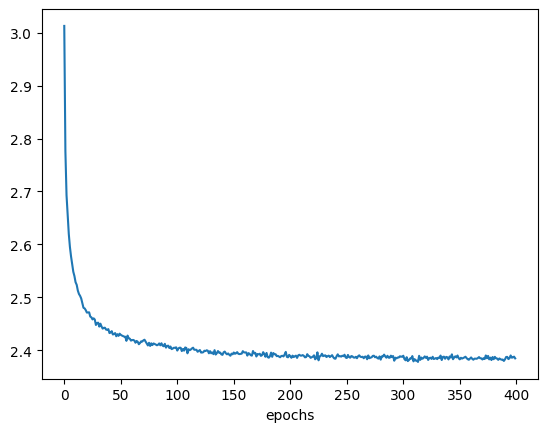

In [60]:
plt.plot(epoch_losses)
plt.xlabel("epochs")


The model's weights are the actual word embeddings. You can load them into a numpy array:


In [61]:
word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()

Now, check the embedded vector for a sample word. Notice the shape of this vector which is equal to the `emsize = 24` that you defined earlier.


In [76]:
# from collections import Counter
# from itertools import chain
# import nltk
# import torch
# from torch.utils.data import DataLoader
# import torch.nn as nn
# import torch.optim as optim

# nltk.download('punkt')  # Ensure NLTK tokenizer is available
# from nltk.tokenize import word_tokenize

# tokenizer = word_tokenize  # Use NLTK's word tokenizer

# # Step 2: Function to tokenize sentences
# def tokenize_data(sentences):
#     """
#     Tokenizes each sentence in the given list of sentences.

#     Args:
#         sentences (list): List of sentences to tokenize.

#     Returns:
#         list: List of tokenized words from each sentence.
#     """
#     return [tokenizer(sentence) for sentence in sentences]

# # Tokenizing toy data (sample toy_data to test the pipeline)
# tokenized_toy_data = tokenize_data(toy_data)

# # Flatten the tokenized data to create a single list of words
# flat_tokenized_data = list(chain(*tokenized_toy_data))

# # Step 3: Build vocabulary from tokenized data with <unk> (unknown) token
# counter = Counter(flat_tokenized_data)  # Count word occurrences
# vocab = {word: idx for idx, (word, _) in enumerate(counter.most_common(), start=1)}
# vocab["<unk>"] = 0  # Assign index 0 to unknown token

# # Test a sample sentence
# sample_sentence = "I wish I was a baller"
# tokenized_sample = tokenizer(sample_sentence)

# # Encode the tokenized words using the vocabulary
# encoded_sample = [vocab.get(token, vocab["<unk>"]) for token in tokenized_sample]

# # Print the encoded representation of the sample sentence
# print("Encoded sample:", encoded_sample)

# # Define a text pipeline for encoding
# def text_pipeline(tokens):
#     return [vocab.get(token, vocab["<unk>"]) for token in tokens]

# # Check if 'baller' is in the vocabulary and print its word embedding
# word = 'baller'

# # Ensure 'baller' exists in vocab
# if word in vocab:
#     word_index = vocab[word]  # getting the index of the word in the vocab
#     print(f"Word index for '{word}': {word_index}")
#     word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()
#     print(word_embeddings[word_index])
# else:
#     print(f"'{word}' is not in the vocabulary. Checking <unk> index...")
#     word_index = vocab["<unk>"]
#     print(f"Using <unk> token embedding: {word_index}")
#     word_embeddings = model_cbow.embedding.weight.detach().cpu().numpy()
#     print(word_embeddings[word_index])  # Print embedding for <unk>


In [77]:
word = 'baller'

# Check if the word exists in the vocab
if word in vocab:
    word_index = vocab[word]  # getting the index of the word in the vocab
    print(word_embeddings[word_index])
else:
    print(f"'{word}' is not in the vocabulary.")

[-0.37268233  0.7730446   0.00286675  0.18596819 -0.08756901 -0.13963117
 -0.3128581   0.5306341   0.1781773   0.01526112 -0.09133023  0.21041386
 -0.01982056  0.33116063  0.3302575  -0.4613755   0.21107204  0.74245965
 -0.00459926 -0.49854013  0.25461784 -1.0076723  -0.01938024 -0.17694472]


Now you can check if embeddings are representing the similarities among words. To do this, for the sake of visualization,you need to do dimension reduction on word embeddings to map the embedding space to a 2-d space. You can do this using TSNE in the plot function in the helper functions section.


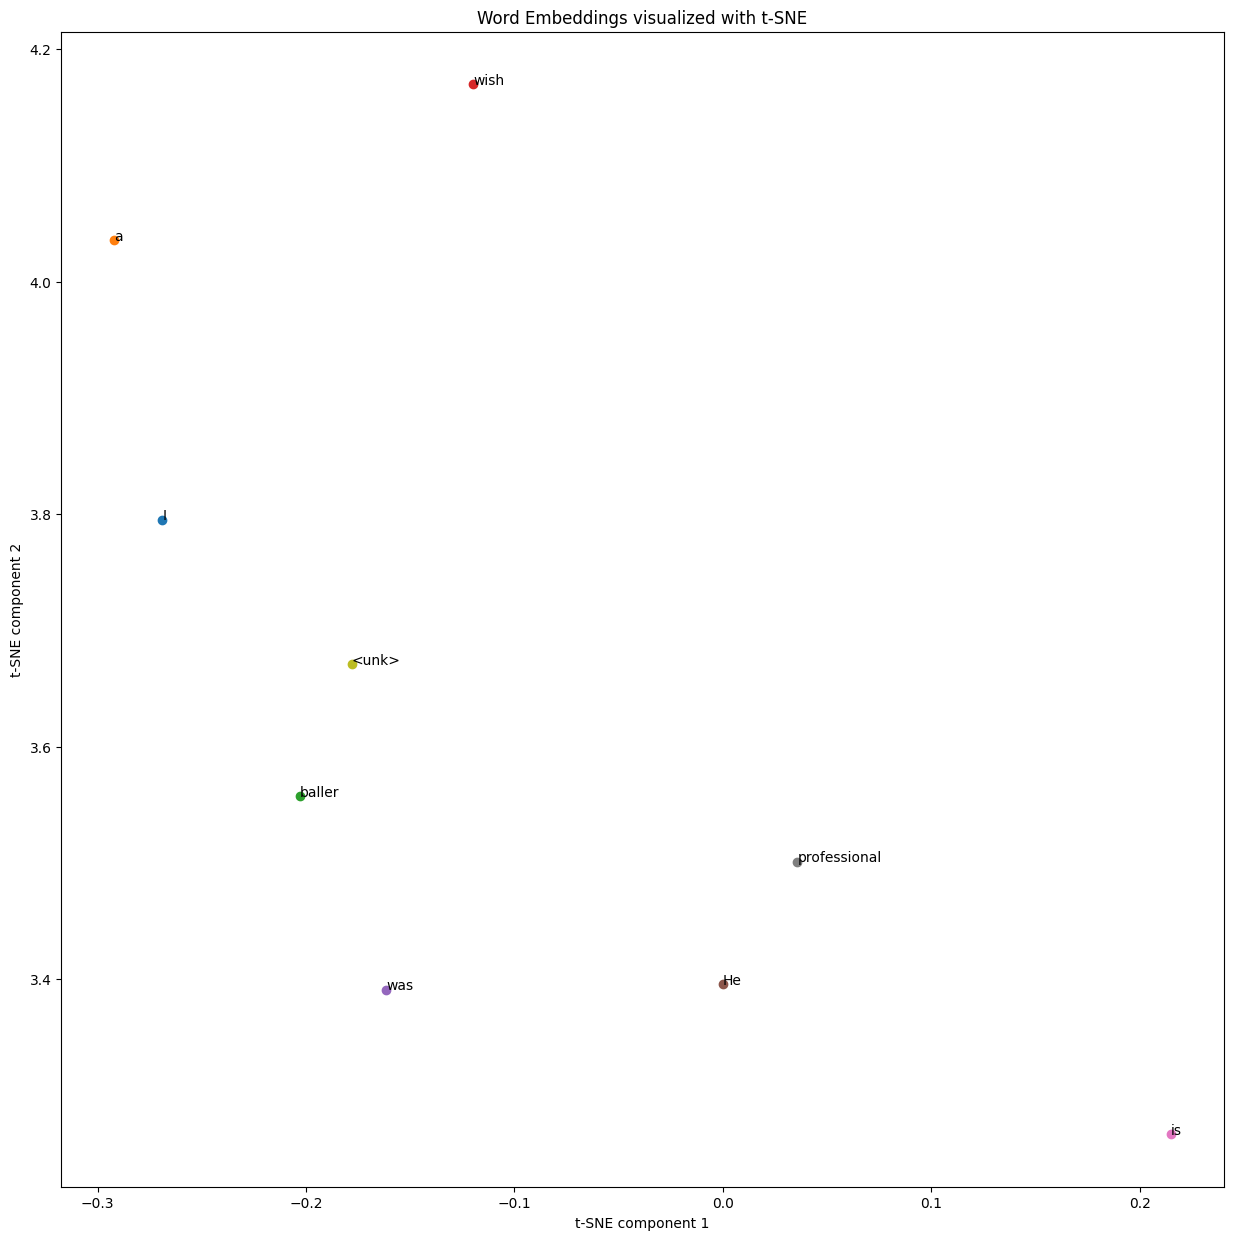

In [78]:
plot_embeddings(word_embeddings,vocab=vocab)

Upon examining the t-SNE projections, it is evident that even with the inevitable information loss from dimensionality reduction and the limitations of a small dataset, words with similar meanings cluster together. For instance, words such as 'bright' and 'shadow' are in proximity near the point (-15, -15) on components 1 and 2. Likewise, 'dog', 'cat', and 'mouse' are grouped around the (5, 5) coordinate, and 'sailed' as well as 'wind' can be found close to the (5, -8) point."


## Skip-gram model

The Skip-gram model is one of the two main architectures used in word2vec, a popular technique for learning word embeddings. In the Skip-gram model, the goal is to predict the surrounding words (context) given a central word (target). The main idea behind this model is that words that appear in similar contexts tend to have similar meanings.  Consider this example:

**I was little bit taller,**

Assuming a context window size of 2, the words in red represent the context, while the word highlighted in blue signifies the target:

**<span style="color:red;"> I was</span> <span style="color:blue;">little</span> <span style="color:red;">bit taller, </span>**

### Window the Skip-gram:

Training the Skip-gram model using the actual context can be computationally expensive. This is because it involves predicting probabilities for each word in the vocabulary for each position in the context as opposed to CBOW that predicts the probabilities for each word in the vocabulary for the target word only. To mitigate this, several approximation techniques are employed.

One common approximation technique is to break the full context into smaller parts and predict them one at a time. This not only simplifies the prediction task but also helps in better training as it provides multiple training examples from a single context-target pair.

### Using the first row of the table as an example:


For the example above the target word is **"little"**. The full context for this target word is:
**I was bit taller**

In the approximation, instead of using the full context to predict the target, you should break it down. There are four approximations in this example:
1. Approximation 1: **I**
2. Approximation 2: **was**
3. Approximation 3: **bit**
4. Approximation 4: **taller**

For each approximation, the Skip-gram model would aim to predict the target word "little" using just that part of the context. This means, for the first approximation, the model will try to predict "little" using only the word "I". For the second approximation, it will try using only the word "was," and so on.

In conclusion, the Skip-gram model aims to understand word relationships by predicting the context from a given target word. Approximation techniques, like the one illustrated, help simplify the training process and make it more efficient.


<table border="1">
    <tr>
        <th>Full Context with Target</th>
        <th>Target Word</th>
        <th>Original Target Context</th>
        <th>Approximation 1</th>
        <th>Approximation 2</th>
        <th>Approximation 3</th>
        <th>Approximation 4</th>
    </tr>
    <tr>
        <td><span style="color:red;"> I was</span> <span style="color:blue;">little</span> <span style="color:red;">bit taller, </span></td>
        <td>little</td>
        <td> I was bit taller,</td>
        <td>I</td>
        <td>was</td>
        <td>bit</td>
        <td>taller,</td>
    </tr>
    <tr>
        <td><span style="color:red;"> was little</span> <span style="color:blue;">bit</span> <span style="color:red;">taller, I </span></td>
        <td>bit</td>
        <td>was little taller, I</td>
        <td>was</td>
        <td>little</td>
        <td>taller,</td>
        <td>I</td>
    </tr>
    <tr>
        <td><span style="color:red;">little bit</span> <span style="color:blue;">taller,</span> <span style="color:red;">I wish </span></td>
        <td>taller,</td>
        <td>little bit I wish</td>
        <td>little</td>
        <td>bit</td>
        <td>I</td>
        <td>wish</td>
    </tr>
    <tr>
        <td><span style="color:red;"> bit taller,</span> <span style="color:blue;">I</span> <span style="color:red;">wish I </span></td>
        <td>I</td>
        <td>bit taller, wish I</td>
        <td>bit</td>
        <td>taller,</td>
        <td>wish</td>
        <td>I</td>
    </tr>
    <tr>
        <td><span style="color:red;"> taller, I</span> <span style="color:blue;">wish</span> <span style="color:red;">I was </span></td>
        <td>wish</td>
        <td>taller, I I was</td>
        <td>taller,</td>
        <td>I</td>
        <td>I</td>
        <td>was</td>
    </tr>
    <!-- More rows can be added in a similar pattern for other words in the phrase. -->
</table>


The goal is to optimize the conditional probabilities for obtaining embeddings. Optimize the conditional probabilities for obtaining high-quality word embeddings. The only difference between continuous bag of words is the structure of the conditional probabilities $P(w_{t+j}| w_{t})$  for your window size $j=-2,-1,..,1,2.$


<table border="1">
    <tr>
        <th>j</th>
        <th>Target Word t=3 </th>
        <th>Context Word</th>
        <th>Probability</th>
    </tr>
    <tr>
         <th>-2</th>
        <td>little</td>
        <td>I</td>
        <td> P(I | little) </td>
    </tr>
    <tr>
          <th>-1</th>
        <td>little</td>
        <td>was</td>
        <td> P(was | little)</td>
    </tr>
    <tr>
         <th>1</th>
        <td>little</td>
        <td>bit</td>
        <td>P(bit | little)</td>
    </tr>
    <tr>
         <th>2</th>
        <td>little</td>
        <td>taller,</td>
        <td>P(taller | little) </td>
    </tr>
    <!-- Repeat rows for each context word for each target word -->
</table>





In contrast to the standard notation in conditional probability, where the dependent variable is typically represented as the target, the current terminology reverses this convention.



<img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-AI0201EN-Coursera/targetvsdepenet.gif" alt="image">




This code constructs a skip-gram dataset from a tokenized toy data, where for each word (target), it gathers the surrounding words within a specified window (context) defined by CONTEXT_SIZE.


In [ ]:
# Define the window size for the context around the target word.
CONTEXT_SIZE = 2

# Initialize an empty list to store the (target, context) pairs.
skip_data = []

# Iterate over each word in the tokenized toy_data, while excluding the first
# and last few words determined by the CONTEXT_SIZE.
for i in range(CONTEXT_SIZE, len(tokenized_toy_data) - CONTEXT_SIZE):

    # For a word at position i, the context comprises of words from the preceding CONTEXT_SIZE
    # as well as from the succeeding CONTEXT_SIZE. The context words are collected in a list.
    context = (
        [tokenized_toy_data[i - j - 1] for j in range(CONTEXT_SIZE)]  # Preceding words
        + [tokenized_toy_data[i + j + 1] for j in range(CONTEXT_SIZE)]  # Succeeding words
    )

    # The word at the current position i is taken as the target.
    target = tokenized_toy_data[i]

    # Append the (target, context) pair to the skip_data list.
    skip_data.append((target, context))


You can window the skipgram


In [ ]:
skip_data_=[[(sample[0],word) for word in  sample[1]] for sample in skip_data]

You will have pairs of (target, context) words:


In [ ]:
skip_data_flat= [item  for items in  skip_data_ for item in items]
skip_data_flat[8:28]

Creating a collate function to numericalize (target, context) pairs:


In [ ]:
def collate_fn(batch):
    target_list, context_list = [], []
    for _context, _target in batch:

        target_list.append(vocab[_target])
        context_list.append(vocab[_context])

    target_list = torch.tensor(target_list, dtype=torch.int64)
    context_list = torch.tensor(context_list, dtype=torch.int64)
    return target_list.to(device), context_list.to(device)

In [ ]:
dataloader = DataLoader(skip_data_flat, batch_size=BATCH_SIZE, collate_fn=collate_fn)

Let's check a sample batch of target,context after collation:


In [ ]:
next(iter(dataloader))

Here, you will define the Skip-gram network.
The embeddings layer is defined using nn.Embedding, which creates word embeddings for the given vocabulary size and embedding dimension.
The fc layer is a fully connected layer with input dimension embed_dim and output dimension vocab_size.

In the forward method, the input text is passed through the embeddings layer to obtain the word embeddings. The output of the embeddings layer is then passed through the fc layer.
The ReLU activation function is applied to the output of the fc layer. The final output is returned.


In [ ]:
class SkipGram_Model(nn.Module):

    def __init__(self, vocab_size, embed_dim):
        super(SkipGram_Model, self).__init__()
        # Define the embeddings layer
        self.embeddings = nn.Embedding(
            num_embeddings=vocab_size,
            embedding_dim=embed_dim
        )

        # Define the fully connected layer
        self.fc = nn.Linear(in_features=embed_dim, out_features=vocab_size)

    def forward(self, text):
        # Perform the forward pass
        # Pass the input text through the embeddings layer
        out = self.embeddings(text)

        # Pass the output of the embeddings layer through the fully connected layer
        # Apply the ReLU activation function
        out = torch.relu(out)
        out = self.fc(out)

        return out

Creating an instance of the model:


In [ ]:
emsize = 24
model_sg = SkipGram_Model(vocab_size, emsize).to(device)

Now you are going to train the model on toy data:


In [ ]:
LR = 5  # learning rate
#BATCH_SIZE = 64  # batch size for training

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_sg.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

In [ ]:
model_sg, epoch_losses=train_model(model_sg, dataloader, criterion, optimizer, num_epochs=400)

In [ ]:
plt.plot(epoch_losses)

You can also plot the word embedding by reducing the dimensions using t-SNE:


In [ ]:
word_embeddings = model_sg.embeddings.weight.detach().cpu().numpy()
plot_embeddings(word_embeddings,vocab=vocab)


When selecting CBOW or Skip-Gram, the best approach often depends on the specifics of your task and data. If your dataset is small but you need to have a good representation of rarer words, Skip-gram might be the better choice. If the computational efficiency is more critical and the rare words are less of a concern, CBOW might be adequate. It's also worth noting that for very small datasets, the benefits of neural word embeddings might be limited, and simpler methods or leveraging pretrained embeddings might be more effective.



# Applying pretrained word embeddings (optional)
## Load Stanford GloVe model

Transfer learning, particularly through the use of pretrained word embeddings, serves as a cornerstone in modern NLP. This approach leverages knowledge gleaned from one task, typically learned over massive datasets, and applies it to another, often more specialized task. The primary advantage of this is twofold: it bypasses the need for enormous computational resources to learn from scratch, and it injects a base layer of linguistic understanding into the model. By using embeddings that have already captured complex language patterns and associations, even models with limited exposure to domain-specific data can exhibit remarkably sophisticated behavior, making transfer learning a strategic shortcut to enhanced performance in NLP.


Let's take a look at the pretrained GloVe model from Stanford:


You can specify the model name and embedding dimension: GloVe(name='GloVe_model_name', dim=300)


In [ ]:
# creating an instance of the 6B version of Glove() model
glove_vectors_6B = GloVe(name ='6B') # you can specify the model with the following format: GloVe(name='840B', dim=300)

In [ ]:
# creating another instance of a bigger Glove() model
#glove_vectors_840B = GloVe()

You must continue with the 6B model as it is lighter. You can load different pretrained GloVe models from torch() using ```torch.nn.Embedding.from_pretrained```.


In [ ]:
# load the glove model pretrained weights into a PyTorch embedding layer
embeddings_Glove6B = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)

Get ready to look into the embedding vectors of this large pretrained model for the words in the corpus:


You can create an array that returns the index of each word in the GloVe model's vocabulary:


In [ ]:
word_to_index = glove_vectors_6B.stoi  # Vocabulary index mapping
word_to_index['team']

You will get the embedded vector for a word:


In [ ]:
embeddings_Glove6B.weight[word_to_index['team']]

Let's see how successful the Glove model is in capturing the similarities between words:


In [ ]:
# an array of example words
words = [
    "taller",
    "short",
    "black",
    "white",
    "dress",
    "pants",
    "big",
    "small",
    "red",
    "blue",
    "smile",
    "frown",
    "race",
    "stroll",
    "tiny",
    "huge",
    "soft",
    "rough",
    "team",
    "individual"
]


Create a dictionary of words and their embeddings


In [ ]:

embedding_dict_Glove6B = {}
for word in words:
    # Get the index of the word from the vocabulary to access its embedding
    embedding_vector = embeddings_Glove6B.weight[word_to_index[word]]
    if embedding_vector is not None:
        # Words not found in the embedding index will be skipped.
        # add the embedding vector of word to the embedding_dict_Glove6B
        embedding_dict_Glove6B[word] = embedding_vector


Now that you have loaded the pretrained embeddings for the sample words, let's check if the model can capture the similarity of words by finding the distance between words:


In [ ]:
# Call the function to find similar words
target_word = "small"
top_k=2
similar_words = find_similar_words(target_word, embedding_dict_Glove6B, top_k)

# Print the similar words
print("{} most similar words to {}:".format(top_k,target_word) ,similar_words)

It can be seen the pretrained GloVe model does quite good job capturing the similarity of words.


# Train a word2vec model from gensim

Here's a simple hands-on exercise to train a word2vec model using `gensim` library.
In this example, you have a small corpus consisting of four sentences.

### Prepare your corpus:


In [ ]:
sentences = [["I", "like", "to", "eat", "pizza"],
             ["Pizza", "is", "my", "favorite", "food"],
             ["I", "enjoy", "eating", "pasta"]]
sentences = [[word.lower() for word in sentence] for sentence in sentences]


The `size` parameter specifies the dimensionality of the word embeddings (in this case, 100). The `window` parameter determines the size of the context window. The `min_count` parameter sets the minimum frequency of a word to be included in the training process. Finally, the `workers` parameter controls the number of threads used for training.


In [ ]:
from gensim.models import Word2Vec

# Create an instance of Word2Vec model
w2v_model = Word2Vec(sentences, vector_size=100, window=3, min_count=1, workers=4)

Create vocab from sentences:


In [ ]:
# Build vocab using the training data
w2v_model.build_vocab(sentences, progress_per=10000)

Train the model:


In [ ]:
# Train the model on your training data
w2v_model.train(sentences, total_examples=w2v_model.corpus_count, epochs=30, report_delay=1)

That's it! You've trained a word2vec model using the `gensim` library. You can now access the word embeddings using `model.wv` and explore various operations such as finding similar words, calculating word similarities, and more.


Use the trained model to find similar words to "pizza" and calculate the similarity between "pizza" and "pasta".


In [ ]:
# Finding similar words
similar_words = w2v_model.wv.most_similar("pizza")
print("Similar words to 'pizza':", similar_words)

# Calculating word similarity
similarity = w2v_model.wv.similarity("pizza", "pasta")
print("Similarity between 'pizza' and 'pasta':", similarity)

The word embeddings obtained from the model would be more meaningful and informative with larger and more diverse training data.


Use the trained model to create a PyTorch embedding layer (just like what you did with the pretrained GloVe model) and use it in any task as an embedding layer.


In [ ]:
# Extract word vectors and create word-to-index mapping
word_vectors = w2v_model.wv
# a dictionary to map words to their index in vocab
word_to_index = {word: index for index, word in enumerate(word_vectors.index_to_key)}

# Create an instance of nn.Embedding and load it with the trained vectors
embedding_dim = w2v_model.vector_size
embedding = torch.nn.Embedding(len(word_vectors.index_to_key), embedding_dim)
embedding.weight.data.copy_(torch.from_numpy(word_vectors.vectors))

# Example usage: get the embedding for a word
word = "pizza"
word_index = word_to_index[word]
word_embedding = embedding(torch.LongTensor([word_index]))
print(f"Word: {word}, Embedding: {word_embedding.detach().numpy()}")

# Text classification using pretrained word embeddings

You are ready to use the embeddings in a task, then. Let's use the pretrained embeddings to classify text data into topics:


First, you must build vocab from the pretrained GloVe:


In [ ]:
from torchtext.vocab import GloVe,vocab
# Build vocab from glove_vectors
# vocab(ordered_dict: Dict, min_freq: int = 1, specials: Optional[List[str]] = None)
vocab = vocab(glove_vectors_6B.stoi, 0,specials=('<unk>', '<pad>'))
vocab.set_default_index(vocab["<unk>"])

In [ ]:
vocab(["<unk>","Hello","hello"])

Next, you need to tokenize text. For this you can use pretrained tokenizers from torch:


In [ ]:
# Define tokenizer

tokenizer = get_tokenizer("basic_english")
# Define functions to process text and labels

Create splits from AG_NEWS() dataset for training, validation and test:


In [ ]:
# Split the dataset into training and testing iterators.
train_iter, test_iter = AG_NEWS()

# Convert the training and testing iterators to map-style datasets.
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)

# Determine the number of samples to be used for training and validation (5% for validation).
num_train = int(len(train_dataset) * 0.85)

# Randomly split the training dat aset into training and validation datasets using `random_split`.
# The training dataset will contain 95% of the samples, and the validation dataset will contain the remaining 5%.
split_train_, split_valid_ = random_split(train_dataset, [num_train, len(train_dataset) - num_train])

Define the class labels:


In [ ]:
# define class labels
ag_news_label = {1: "World", 2: "Sports", 3: "Business", 4: "Sci/Tec"}
'''ag_news_label[y]'''
num_class = len(set([label for (label, text) in train_iter ]))

Collate data in batches:


In [ ]:
def text_pipeline(x):
    x=x.lower()# you need this as your vocab is in lower case
    return vocab(tokenizer(x))

def label_pipeline(x):
    return int(x) - 1

# create label, text and offset for each batch of data
# text is the concatenated text for all text data in the batch
# you need to have the offsets(the end of text index) for later when you separate texts and predict their label
def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)


Create data loaders for train, validation and test splits:


In [ ]:
BATCH_SIZE = 64

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [ ]:
label, text, offsets=next(iter(train_dataloader ))
print(label, text, offsets)
label.shape, text.shape, offsets.shape

Create the classifier model:


In [ ]:
class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = torch.nn.Embedding.from_pretrained(glove_vectors_6B.vectors,freeze=True)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text,offsets):
        embedded = self.embedding(text)
        # you get the average of word embeddings in the text
        means = []
        for i in range(1,len(offsets)):
            #this is like eme
          text_tmp = embedded[offsets[i-1]:offsets[i]]
          means.append(text_tmp.mean(0))

        return self.fc(torch.stack(means))

Define an evaluate function to calculate the accuracy of model:


In [ ]:
def evaluate(dataloader):
    model.eval()
    total_acc, total_count= 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text,offsets)

            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)
    return total_acc / total_count

Create an instance of the model and check its prediction power before training:


In [ ]:
# Define hyperparameters
vocab_size=len(vocab)
embedding_dim = 300
# Initialize the model
model = TextClassificationModel(vocab_size, embedding_dim, num_class).to(device)

In [ ]:
evaluate(test_dataloader)

Not good! Let's train the model:


In [ ]:
def train_TextClassification(model,dataloader,criterion,optimizer,epochs=10):

    cum_loss_list=[]
    acc_epoch=[]
    acc_old=0

    for epoch in tqdm(range(1, EPOCHS + 1)):
        model.train()
        cum_loss=0
        for idx, (label, text, offsets) in enumerate(train_dataloader):
            means = []
            optimizer.zero_grad()


            predicted_label = model(text, offsets)

            loss = criterion(predicted_label, label)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
            optimizer.step()
            cum_loss+=loss.item()

        cum_loss_list.append(cum_loss/len(train_dataloader))
        accu_val = evaluate(valid_dataloader)
        acc_epoch.append(accu_val)

        if accu_val > acc_old:
          acc_old= accu_val
          torch.save(model.state_dict(), 'my_model.pth')

    return model,cum_loss_list,acc_epoch


In [ ]:
# Define hyperparameters
LR=0.1
EPOCHS = 10


criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)

model,cum_loss_list,acc_epoch  = train_TextClassification(model,train_dataloader,criterion,optimizer,EPOCHS)

Let's plot the loss and accuracy for the trained model:


In [ ]:
import matplotlib.pyplot as plt
def plot(COST,ACC):
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(COST, color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis='y', color=color)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # you already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped

    plt.show()

In [ ]:
plot(cum_loss_list,acc_epoch)

Finally, evaluate the model on test data:


In [ ]:
evaluate(test_dataloader)

Great job! You've acquired the skills to create and train embedding models, as well as utilize large pretrained models for practical applications. This knowledge opens up a world of possibilities where you can leverage the power of embeddings to improve various natural language processing tasks. Keep up the excellent work!


## Authors


Fateme Akbari


```{## Change Log}
```


```{|Date (YYYY-MM-DD)|Version|Changed By|Change Description||-|-|-|-||2023-10-16|0.1|Fateme|Create Lab Template|}
```


© Copyright IBM Corporation. All rights reserved.
